#### Setup

In [8]:
# standard imports 
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
from ipdb import set_trace
import json

# jupyter setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

# own modules
from dataloader import CAL_Dataset
from net import get_model
from dataloader import get_data, get_mini_data
from train import fit, custom_loss, validate
from metrics import calc_metrics

# paths
data_path = './dataset/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


uncomment the cell below if you want your experiments to yield always the same results

In [9]:
# manualSeed = 42

# np.random.seed(manualSeed)
# torch.manual_seed(manualSeed)

# # if you are using GPU
# torch.cuda.manual_seed(manualSeed)
# torch.cuda.manual_seed_all(manualSeed)

# torch.backends.cudnn.enabled = False 
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

In [10]:
def save_json(f, path):
    with open(path + '.json', 'w') as json_file:  
        json.dump(f, json_file)
        
def load_json(path):
    with open(path + '.json', 'r') as json_file:  
        f = json.load(json_file)
    return f

#### Training

Initialize the model. Possible Values for the task block type: MLP, LSTM, GRU, TempConv

In [11]:
params = {'name': 'test', 'type_': 'MLP', 'lr': 3e-4, 
          'n_h': 128, 'p':0.5, 'seq_len':1}

In [12]:
save_json(params, f"models/{params['name']}")

In [13]:
model, opt = get_model(params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

get the data loader. get mini data gets only a subset of the training data, on which we can try if the model is able to overfit

In [14]:
train_dl, valid_dl = get_data(data_path, model.params.seq_len, batch_size=16)
# train_dl, valid_dl = get_mini_data(data_path, model.params.seq_len, batch_size=16, l=4000)

In [17]:
train_ds = CAL_Dataset(data_path, 'train', seq_len=5)

In [26]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms

In [21]:
test_im = train_ds.transform(Image.open(train_ds.im_paths[0]))

In [28]:
class Rescale(object):
    def __init__(self, scalar):
        self.scalar = scalar

    def __call__(self, im):
        w, h = [int(s*self.scalar) for s in im.size]
        return transforms.Resize((h, w))(im)

class Crop(object):
    def __init__(self, box):
        assert len(box) == 4
        self.box = box

    def __call__(self, im):
        return im.crop(self.box)

In [39]:
t = transforms.Compose([
            Crop((0,120,800,480)),
            Rescale(0.4),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

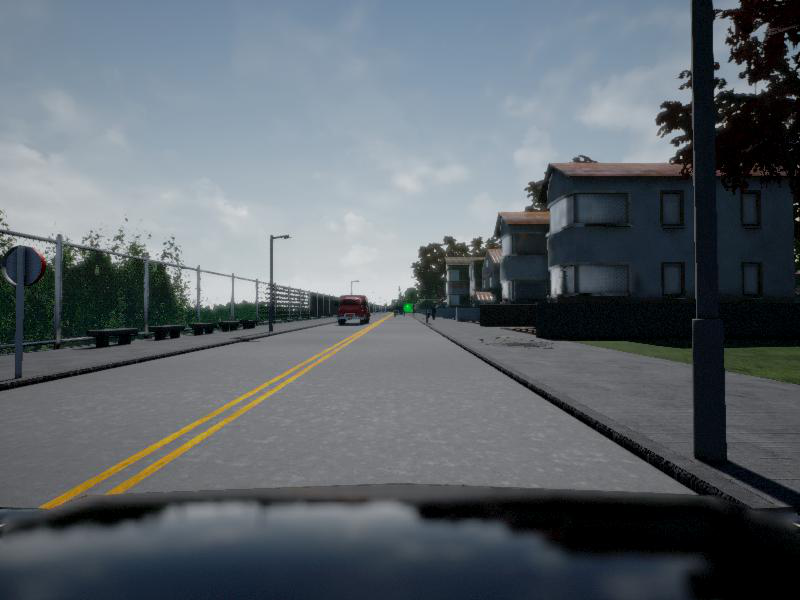

In [40]:
Image.open(train_ds.im_paths[0])

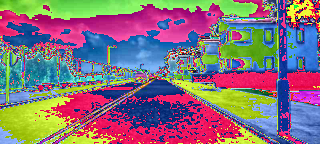

In [41]:
to_pil_image(t(Image.open(train_ds.im_paths[0])))

Train the model. We automatically save the model with the lowest val_loss. If you want to continue the training and keep the loss history, just pass it as an additional argument as shown below.

In [15]:
model, val_hist = fit(1, model, custom_loss, opt, train_dl, valid_dl)

  0%|          | 20/27534 [00:20<1:42:35,  4.47it/s] 

KeyboardInterrupt: 

In [ ]:
# model, val_hist = fit(1, model, custom_loss, opt, train_dl, valid_dl, val_hist=val_hist)

uncomment the next cell if the feature extractor should also be trained

In [ ]:
# for name,param in model.named_parameters():
#     param.requires_grad = True
# opt = optim.Adam(model.parameters())

In [ ]:
# model, val_hist = fit(1, model, custom_loss, opt, train_dl, valid_dl)

In [ ]:
plt.plot(val_hist)

#### evalute the model

In [14]:
name = 'gru'
params = load_json(f"models/{name}")

In [20]:
model, _ = get_model(params)
model.load_state_dict(torch.load(f"./models/{name}.pth"))
model.eval().to(device);
_, valid_dl = get_data(data_path, model.params.seq_len, batch_size=16)

In [22]:
_, all_preds, all_labels = validate(model, valid_dl, custom_loss)

100%|██████████| 1494/1494 [33:54<00:00,  1.31s/it]

0.008826140111626763


In [23]:
calc_metrics(all_preds, all_labels)

{'red_light_val_acc': 97.82017488807999,
 'red_light_IoU': 84.50293740970099,
 'hazard_stop_val_acc': 99.26990502489436,
 'hazard_stop_IoU': 82.67147279218854,
 'speed_sign_val_acc': 99.06489268231455,
 'speed_sign_IoU': 86.63423493538414,
 'relative_angle_MAE_mean': 0.11879962,
 'center_distance_MAE_mean': 0.3321837,
 'veh_distance_MAE_mean': 0.31114423}

In [ ]:
# GRU: 
#  eval: 0.008826
# {'red_light_val_acc': 97.82017488807999,
#  'red_light_IoU': 84.50293740970099,
#  'hazard_stop_val_acc': 99.26990502489436,
#  'hazard_stop_IoU': 82.67147279218854,
#  'speed_sign_val_acc': 99.06489268231455,
#  'speed_sign_IoU': 86.63423493538414,
#  'relative_angle_MAE_mean': 0.11879964,
#  'center_distance_MAE_mean': 0.33218363,
#  'veh_distance_MAE_mean': 0.31114423}

In [27]:
model

CAL_network(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2,

#### plot results

In [24]:
# for convience, we can pass an integer instead of the full string
int2key = {0: 'red_light', 1:'hazard_stop', 2:'speed_sign', 
           3:'relative_angle', 4: 'center_distance', 5: 'veh_distance'}

In [25]:
def plot_preds(k, all_preds, all_labels, start=0, delta=1000):
    if isinstance(k, int): k = int2key[k]
    
    # get preds and labels
    class_labels = ['red_light', 'hazard_stop', 'speed_sign']
    pred = np.argmax(all_preds[k], axis=1) if k in class_labels else all_preds[k]
    label = all_labels[k][:, 1] if k in class_labels else all_labels[k]
    
    plt.plot(pred[start:start+delta], 'r--', label='Prediction', linewidth=2.0)
    plt.plot(label[start:start+delta], 'g', label='Ground Truth', linewidth=2.0)
    
    plt.legend()
    plt.grid()
    plt.show()

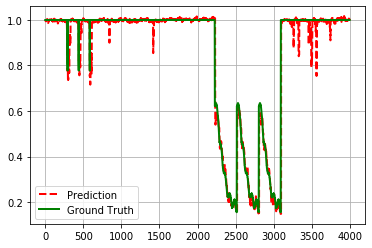

In [26]:
plot_preds(5, all_preds, all_labels, start=0, delta=4000)